# <font color='blue'>Mini-Projeto</font>
## Prever a Intenção de Compra de Usuários de E-Commerce

Definição do Problema:

Avaliar quais atributos influenciam um usuário na compra de produtos online e construir um modelo preditivo para realizar previsões de compras futuras.

Usaremos como fonte de dados o dataset:

Online Shoppers Purchasing Intention Dataset

https://archive.ics.uci.edu/ml/datasets/Online+Shoppers+Purchasing+Intention+Dataset

O conjunto de dados consiste em vetores de recursos pertencentes a 12.330 sessões online. O conjunto de dados foi formado de modo que cada sessão pertença a um usuário diferente em um período de 1 ano para evitar qualquer tendência para uma campanha específica, dia especial, usuário, perfil ou período.

O conjunto de dados consiste em 10 atributos numéricos e 8 categóricos. O atributo 'Revenue' pode ser usado como o rótulo da classe.

## Importando os Pacotes

In [125]:
# Imports
from pyspark.sql import Row
from pyspark.ml.linalg import Vectors
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
from pyspark.sql.functions import col, sum, countDistinct
import pyspark.sql.functions as f
import chart_studio.plotly as py
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from plotly.subplots import make_subplots
from pyspark.sql.types import DoubleType

In [78]:
# Carregando os dados
sc = SparkContext.getOrCreate();
spark = SparkSession(sc)
df_original = spark.read.format("csv").option("header","true").load("data/online_shoppers_intention.csv")

Dados:

* As colunas Administrativo, Duração administrativa, Informativo, Duração informativo, Relacionado ao produto e Duração relacionada ao produto: representam o número de diferentes tipos de páginas visitadas pelo visitante nessa sessão e o tempo total gasto em cada uma dessas categorias de página. 

* Taxa de rejeição, Taxa de saída e Valor da página: representam as métricas medidas pelo "Google Analytics" para cada página no site de comércio eletrônico. 

* Taxa de rejeição de uma página da web: refere-se à porcentagem de visitantes que entram no site a partir dessa página e saem ("rejeição") sem acionar outras solicitações ao servidor durante essa sessão. 

* Taxa de saída para uma página da web: específica é calculado como a porcentagem que foi a última na sessão, para todas as exibições de página a página. 

* Valor da página: representa o valor médio para uma página da web que um usuário visitou antes de concluir uma transação de comércio eletrônico. 

* Dia especial: indica a proximidade do horário de visita do site a um dia especial específico (por exemplo, dia das mães, dia dos namorados) em que as sessões têm mais probabilidade de serem finalizadas com a transação. 

* O conjunto de dados também inclui o tipo de sistema operacional, navegador, região, tipo de tráfego, tipo de visitante como visitante novo ou recorrente, um valor booleano indicando se a data da visita é final de semana e mês do ano.

* A variável observada (Revenue) é booleana, com True se a sessão gerou receita e False se não gerou.

## Análise Exploratória

In [79]:
# Número de linhas e columnas
print((df_original.count(), len(df_original.columns)))

(12330, 18)


In [9]:
# Tipos de dados
df_original.printSchema()

root
 |-- Administrative: string (nullable = true)
 |-- Administrative_Duration: string (nullable = true)
 |-- Informational: string (nullable = true)
 |-- Informational_Duration: string (nullable = true)
 |-- ProductRelated: string (nullable = true)
 |-- ProductRelated_Duration: string (nullable = true)
 |-- BounceRates: string (nullable = true)
 |-- ExitRates: string (nullable = true)
 |-- PageValues: string (nullable = true)
 |-- SpecialDay: string (nullable = true)
 |-- Month: string (nullable = true)
 |-- OperatingSystems: string (nullable = true)
 |-- Browser: string (nullable = true)
 |-- Region: string (nullable = true)
 |-- TrafficType: string (nullable = true)
 |-- VisitorType: string (nullable = true)
 |-- Weekend: string (nullable = true)
 |-- Revenue: string (nullable = true)



In [12]:
# Verificando valores missing
df_original.select(*(sum(col(c).isNull().cast("int")).alias(c) for c in df_original.columns)).toPandas()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,14,14,14,14,14,14,14,14,0,0,0,0,0,0,0,0,0,0


In [80]:
# Ao invés de imputar os dados eu optei por remover os valores esquecidos
# já que não são muitos
df_original = df_original.na.drop()

In [29]:
# Número de linhas e columnas
print((df_original.count(), len(df_original.columns)))

(12316, 18)


In [35]:
# Verificando Valores Únicos
df_original.distinct().count()

12199

In [43]:
df_original.Administrative

Column<b'Administrative'>

In [118]:
# Listas vazias para os resultados
continuous = []
categorical = []

for name in df_original.schema.names:
    if (df_original.select(f.col(name)).distinct().count() > 30):
        print(name)
        #auxx = df_original.select(f.col(name).cast(DoubleType()))
        df_original = df_original.withColumn(name,f.col(name).cast(DoubleType()))
        continuous.append(name)
    else:
        categorical.append(name)
    #print(df_original[name].distinct.count())

Administrative_Duration
Informational_Duration
ProductRelated
ProductRelated_Duration
BounceRates
ExitRates
PageValues


In [95]:
df_original.printSchema()

root
 |-- Administrative: string (nullable = true)
 |-- Administrative_Duration: double (nullable = true)
 |-- Informational: string (nullable = true)
 |-- Informational_Duration: double (nullable = true)
 |-- ProductRelated: double (nullable = true)
 |-- ProductRelated_Duration: double (nullable = true)
 |-- BounceRates: double (nullable = true)
 |-- ExitRates: double (nullable = true)
 |-- PageValues: double (nullable = true)
 |-- SpecialDay: string (nullable = true)
 |-- Month: string (nullable = true)
 |-- OperatingSystems: string (nullable = true)
 |-- Browser: string (nullable = true)
 |-- Region: string (nullable = true)
 |-- TrafficType: string (nullable = true)
 |-- VisitorType: string (nullable = true)
 |-- Weekend: string (nullable = true)
 |-- Revenue: string (nullable = true)



In [54]:
categorical

['Administrative',
 'Informational',
 'SpecialDay',
 'Month',
 'OperatingSystems',
 'Browser',
 'Region',
 'TrafficType',
 'VisitorType',
 'Weekend']

In [72]:
continuous

['Administrative_Duration',
 'Informational_Duration',
 'ProductRelated',
 'ProductRelated_Duration',
 'BounceRates',
 'ExitRates',
 'PageValues']

In [114]:
# Converte para pandas para plotar
df_ = df_original.toPandas()

In [63]:
# Seleciona apenas as colunas das variáveis contínuas para plotagem
df_plot = df_[continuous].astype(float)

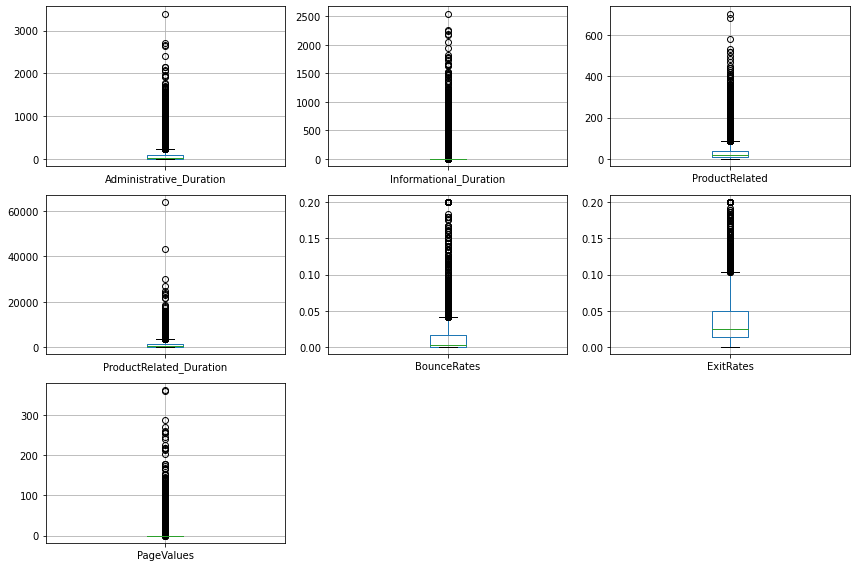

In [101]:
# Tamanho da área de plotagem
fig = plt.figure(figsize = (12,8))

# Loop pelas variáveis contínuas
for i, col in enumerate(continuous):
    plt.subplot(3, 3, i + 1);
    df_plot.boxplot(col);
    plt.tight_layout()
    
plt.savefig('imagens/boxplot1.png')

Variáveis contínuas parecem extremamente distorcidas. Vamos aplicar transformação de log para melhor visualização.

In [108]:
# Transformação de log nas variáveis contínuas
df_plot = np.log1p(1 + df_plot)

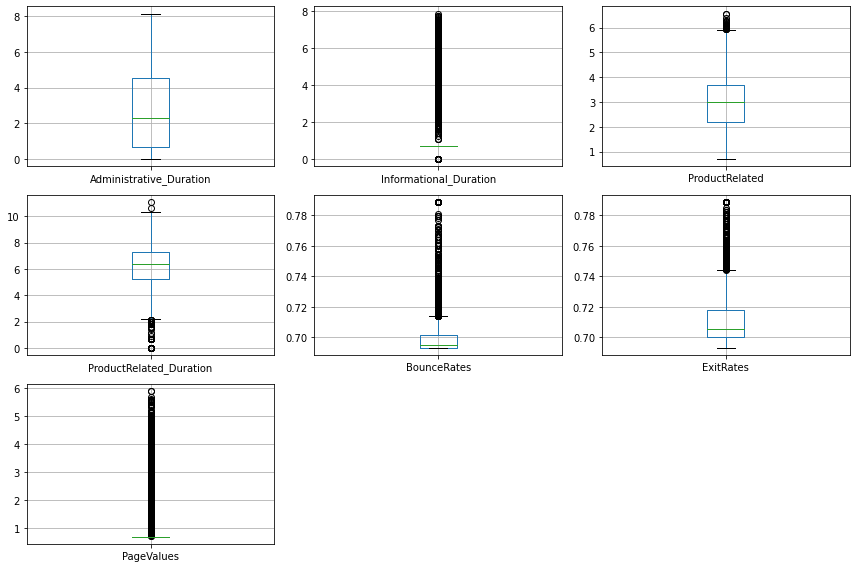

In [109]:
# Plot das variáveis contínuas

# Tamanho da área de plotagem
fig = plt.figure(figsize = (12,8))

# Loop pelas variáveis contínuas
for i,col in enumerate(continuous):
    plt.subplot(3,3,i+1);
    df_plot.boxplot(col);
    plt.tight_layout()
plt.savefig('imagens/boxplot2.png')

Matriz de Correlação Entre Variáveis Contínuas.

<AxesSubplot:>

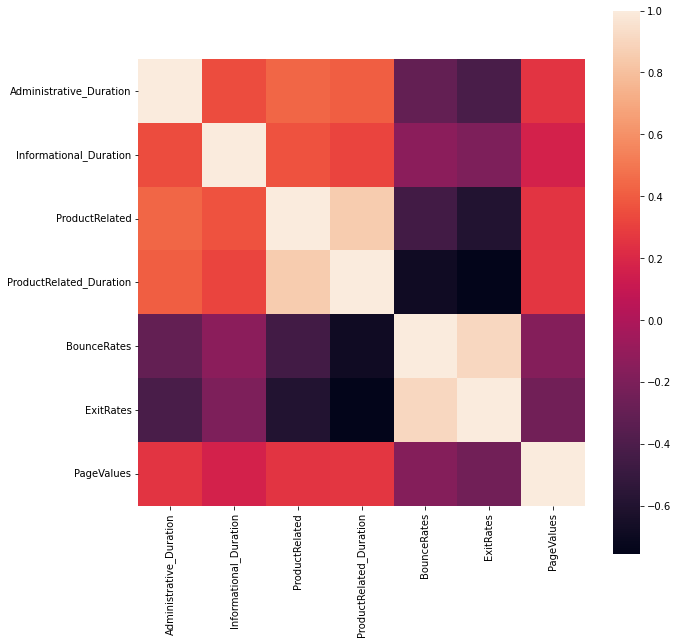

In [113]:
# Área de plotagem
plt.figure(figsize = (10,10))

# Matriz de Correlação 
sns.heatmap(df_plot.corr(), vmax = 1., square = True)

Visualização de gráficos de variáveis categóricas para analisar como a variável de destino é influenciada por elas.

In [120]:
# Agora vamos analisar as variáveis categóricas
df_plot = df_[categorical]

C:\Users\Jaqueline\Anaconda3\envs\spark\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



<AxesSubplot:title={'center':'Venda ou Não'}, xlabel='Revenue', ylabel='count'>

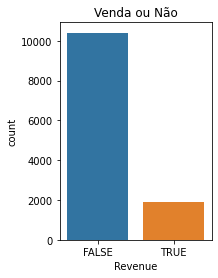

In [121]:
# Countplot Venda ou Não
plt.subplot(1,2,2)
plt.title("Venda ou Não")
sns.countplot(df_plot['Revenue'])

C:\Users\Jaqueline\Anaconda3\envs\spark\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



<AxesSubplot:xlabel='VisitorType', ylabel='count'>

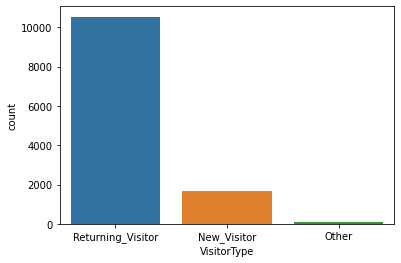

In [123]:
# Countplot Tipo de Visitante
plt.xlabel("Tipo de Visitante")
sns.countplot(df_plot['VisitorType'])

<AxesSubplot:xlabel='VisitorType'>

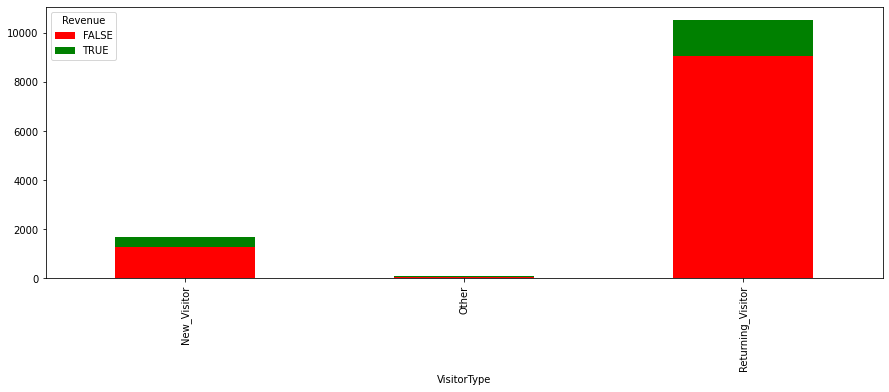

In [126]:
# Stacked Bar Tipo de Visitante x Revenue
pd.crosstab(df_plot['VisitorType'], df_plot['Revenue']).plot(kind = 'bar', 
                                                   stacked = True, 
                                                   figsize = (15, 5), 
                                                   color = ['red', 'green'])

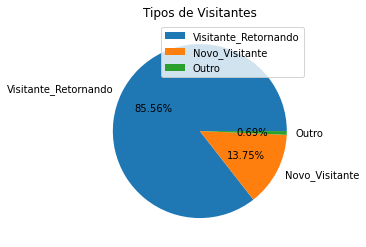

In [127]:
# Pie Chart Tipos de Visitantes
labels = ['Visitante_Retornando', 'Novo_Visitante', 'Outro']
plt.title("Tipos de Visitantes")
plt.pie(df_plot['VisitorType'].value_counts(), labels = labels, autopct = '%.2f%%')
plt.legend()

C:\Users\Jaqueline\Anaconda3\envs\spark\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



<AxesSubplot:title={'center':'Final de Semana ou Não'}, xlabel='Weekend', ylabel='count'>

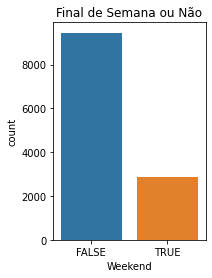

In [128]:
# Countplot Final de Semana ou Não
plt.subplot(1,2,1)
plt.title("Final de Semana ou Não")
sns.countplot(df_plot['Weekend'])

<AxesSubplot:xlabel='Weekend'>

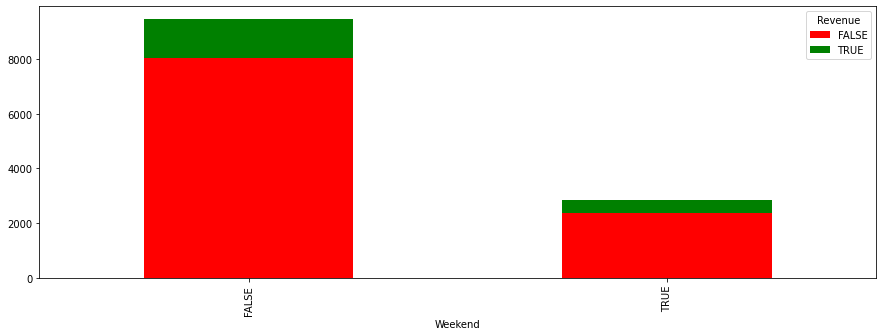

In [129]:
# Stacked Bar Final de Semana x Revenue
pd.crosstab(df_plot['Weekend'], df_plot['Revenue']).plot(kind = 'bar', 
                                               stacked = True, 
                                               figsize = (15, 5), 
                                               color = ['red', 'green'])

C:\Users\Jaqueline\Anaconda3\envs\spark\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



<AxesSubplot:title={'center':'Tipos de Sistemas Operacionais'}, xlabel='OperatingSystems', ylabel='count'>

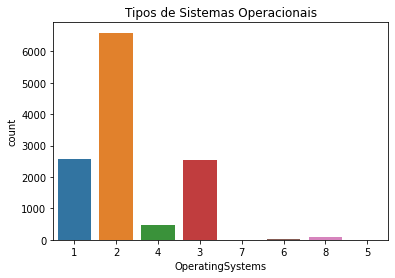

In [130]:
# Countplot Tipos de Sistemas Operacionais
#plt.figure(figsize = (15,6))
plt.title("Tipos de Sistemas Operacionais")
plt.xlabel("Sistema Operacional Usado")
sns.countplot(df_plot['OperatingSystems'])

<AxesSubplot:xlabel='OperatingSystems'>

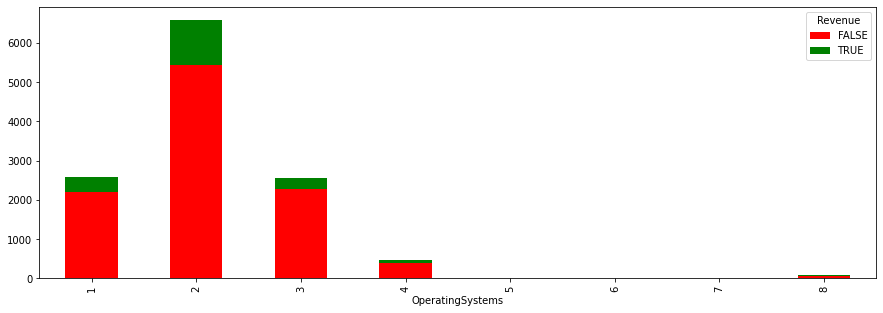

In [131]:
# Stacked Bar Tipo de SO x Revenue
pd.crosstab(df_plot['OperatingSystems'], df_plot['Revenue']).plot(kind = 'bar', 
                                                        stacked = True, 
                                                        figsize = (15, 5), 
                                                        color = ['red', 'green'])

C:\Users\Jaqueline\Anaconda3\envs\spark\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



<AxesSubplot:title={'center':'Tipos de Tráfego'}, xlabel='TrafficType', ylabel='count'>

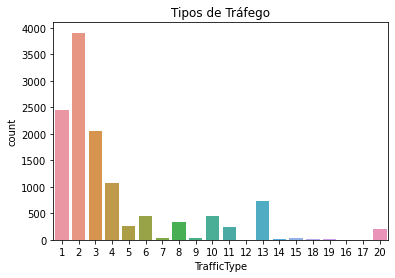

In [132]:
# Countplot Tipo de Tráfego
plt.title("Tipos de Tráfego")
plt.xlabel("Tipo de Tráfego")
sns.countplot(df_plot['TrafficType'])

<AxesSubplot:xlabel='TrafficType'>

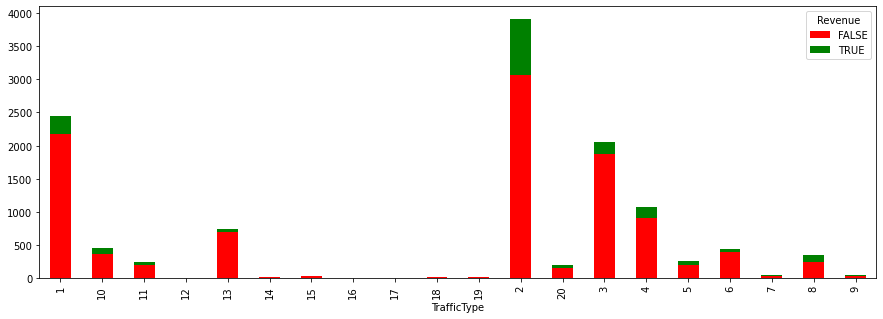

In [133]:
# Stacked Bar Tipos de Tráfego x Revenue
pd.crosstab(df_plot['TrafficType'], df_plot['Revenue']).plot(kind = 'bar', 
                                                   stacked = True, 
                                                   figsize = (15, 5), 
                                                   color = ['red', 'green'])

## Pré-Processamento dos Dados

Agora que já exploramos e conhecemos o dataset vamos realizar processamentos nos dados os quais serviram de entrada para um algoritmo a fim de construir um modelo.